In [1]:
import os
import time

import h5py
import numpy as np

import matplotlib.pyplot as plt
import IPython.display as disp

from dataproc.dataproc import get_worm_data_files, explore_worm_files

In [2]:
# Get one example file set.

data_path = "./data_01/data"

main_file, feature_file, containing_dir_name = next(get_worm_data_files(data_path))

## Preprocessing of coordinates

###  View skeleton

In [3]:
# Notation: dc --> dorsal_contours
# Notation: vc --> ventral_contours
# Notation: sk --> skeletons
# Notation: skid --> skeleton_id

def retrieve_coordinates(f):
    dc = f["coordinates"]["dorsal_contours"]
    vc = f["coordinates"]["ventral_contours"]
    sk = f["coordinates"]["skeletons"]
    return dc, vc, sk

def retrive_skeleton_ids(f):
    skid = f["features_timeseries"]["skeleton_id"]
    return skid

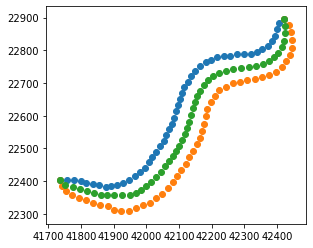

skid: 


In [4]:
# View some skeleton frames.

def view_coord_frames(dc, vc, sk, skid, from_=0, to=None, print_raw=False):
    
    if to is None:
        to = skid.shape[0]
    
    for t in range(from_, to):

        x_dc = dc[t, :, 0]
        y_dc = dc[t, :, 1]
        plt.scatter(x_dc, y_dc)

        x_vc = vc[t, :, 0]
        y_vc = vc[t, :, 1]
        plt.scatter(x_vc, y_vc)
        
        x_sk = sk[t, :, 0]
        y_sk = sk[t, :, 1]
        plt.scatter(x_sk, y_sk)

        ax = plt.gca()
        ax.set_aspect("equal")
        
        disp.display(plt.gcf())
        
        time.sleep(0.1)
        
        assert skid.shape[0] == dc.shape[0]
        
        print("skid: ".format(skid[t]))
        if skid[t] == -1:
            print("MISSING SKELETON!")
        
        if print_raw:
            print("x_dc={}".format(x_dc))
            print("y_dc={}".format(y_dc))
            print("x_vc={}".format(x_vc))
            print("y_vc={}".format(y_vc))
            print("x_sk={}".format(x_sk))
            print("y_sk={}".format(y_sk))
            print("skid[t]={}".format(skid[t]))
        
        disp.clear_output(wait=True)
        plt.close()

with h5py.File(feature_file, "r") as f:
    
    dc, vc, sk = retrieve_coordinates(f)
    skid = retrive_skeleton_ids(f)
    
    view_coord_frames(dc, vc, sk, skid, from_=200, to=220)
    

###  Normalise

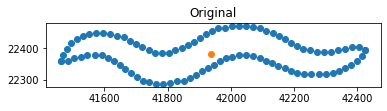

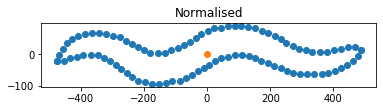

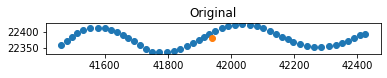

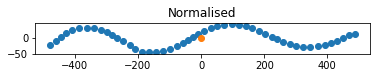

In [5]:
# Normalise (1) dorsal / ventral contours; (2) skeleton (center-line).

# NOTE: The contour is ordered in a continuous way (going [dc, vc]).
# Notation: com --> Centre of Mass

def normalise_dc_vc(dc, vc, limit=None):
    len_coords = dc.shape[1]
    num_frames = limit if ((limit is not None) and (dc.shape[0] > limit)) else dc.shape[0]
    
    frame_data = np.zeros((num_frames, len_coords * 2, 2))
    com = np.zeros((num_frames, 1, 2))
    
    for idx in range(num_frames):
        combined = np.stack((dc[idx, :, :], vc[idx, :, :]))
        frame_data[idx, :, :] = combined.reshape((-1, 2))
        com[idx, 0, :] = frame_data[idx, :, :].mean(axis=0)
    
    frame_data_norm = frame_data - com
    
    return frame_data, frame_data_norm, com

def normalise_sk(sk, limit=None):
    len_coords = sk.shape[1]
    num_frames = limit if ((limit is not None) and (sk.shape[0] > limit)) else sk.shape[0]
    
    frame_data = np.zeros((num_frames, len_coords, 2))
    com = np.zeros((num_frames, 1, 2))
    
    for idx in range(num_frames):
        frame_data[idx, :, :] = sk[idx, :, :].reshape((-1, 2))
        com[idx, 0, :] = frame_data[idx, :, :].mean(axis=0)
    
    frame_data_norm = frame_data - com
    
    return frame_data, frame_data_norm, com

def view_normalisation(frame_data, frame_data_norm, com, t=19):
    
    fig1 = plt.figure()
    plt.scatter(frame_data[t, :, 0], frame_data[t, :, 1])
    plt.scatter(com[t, 0, 0], com[t, 0, 1])
    plt.title("Original")
    ax = plt.gca()
    ax.set_aspect("equal")
    
    fig2 = plt.figure()
    plt.scatter(frame_data_norm[t, :, 0], frame_data_norm[t, :, 1])
    plt.scatter([0], [0])
    plt.title("Normalised")
    ax = plt.gca()
    ax.set_aspect("equal")

with h5py.File(feature_file, "r") as f:
    
    dc, vc, sk = retrieve_coordinates(f)
    
    frame_data, frame_data_norm, com = normalise_dc_vc(dc, vc, limit=500)
    view_normalisation(frame_data, frame_data_norm, com, t=19)
    
    frame_data, frame_data_norm, com = normalise_sk(sk, limit=500)
    view_normalisation(frame_data, frame_data_norm, com, t=19)

### Missing frames

In [6]:
# Longest run detector helper.

arr = np.array([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1])

def longest_run(arr, value):
    max_run = 0
    bools = (arr == value).astype(int)
    if np.any(bools):
        bounded = np.hstack(([0], bools, [0]))
        diffs = np.diff(bounded)
        run_starts = np.where(diffs > 0)[0]
        run_ends = np.where(diffs < 0)[0]
        runs = run_ends - run_starts
        max_run = runs.max()
    return max_run

longest_run(arr, 1)

4

In [7]:
# Info on missing skeleton frames.

def missing_frames_info(missg, missing_indicator=-1):
    
    len_ = missg.shape[0]
    missing_count = (missg == missing_indicator).sum()
    missing_max_run = longest_run(missg, missing_indicator) 
    
    print("Missing skeletons: {}/{} ({:.3}%)".format(missing_count, len_, missing_count / len_ * 100))
    print("Longest run of missing skeletons: {}/{} ({:.3}%)".format(missing_max_run, len_, missing_max_run / len_ * 100))

with h5py.File(feature_file, "r") as f:
    
    skid = retrive_skeleton_ids(f)
    missing_frames_info(skid)

Missing skeletons: 471/26997 (1.74%)
Longest run of missing skeletons: 207/26997 (0.767%)


### Downsampling

In [8]:
# Experiment with downsampling, can be skipped.
SKIP_CELL = True
if not SKIP_CELL:

    KEEP_REPEATED = False

    mis = np.array([-1,-1, 2, 3, 4, 5, 6, 7, 8,-1,-1,-1,-1,13,14,15,16,17,-1,-1,-1,21,22,23,24,25,26,27,28,-1,30])

    period = 3
    missing_indicator = -1

    indices = np.array(range(len(mis)))
    # print("indices", indices)
    mod = np.remainder(indices, period)
    # print("mod", mod)
    take = (mod == 0).astype(int)
    print("take", take)

    mis_bool = (mis == missing_indicator).astype(int)
    print("mis_bool", mis_bool)

    mis_bool_inv = 1 - mis_bool
    print("mis_bool_inv", mis_bool_inv)

    comp = (mis_bool_inv & take).astype(int)
    print("comp", comp)
    comp_idx = np.where(comp)[0]
    print("* comp_idx", comp_idx)

    needs_filling = (mis_bool & take).astype(int)
    print("needs_filling", needs_filling)

    needs_filling_idx = np.where(needs_filling)[0]
    print("needs_filling_idx", needs_filling_idx)

    print("--------------------")
    bounded = np.hstack(([0], mis_bool, [0]))
    diffs = np.diff(bounded)
    run_starts = np.where(diffs[1:] > 0)[0]
    run_ends = np.where(diffs[:-1] < 0)[0]
    run_edges = np.sort(np.concatenate((run_starts, run_ends)))
    print("run_starts", run_starts)
    print("run_ends", run_ends)
    print("run_edges", run_edges)

    print("--------------------")
    fill = np.zeros((needs_filling_idx.shape[0])).astype(int)
    for enum_idx, idx in enumerate(needs_filling_idx):
        diff = np.absolute(run_edges - idx)
        diff_argmin = diff.argmin()
        print("diff", diff)
        print("diff_argmin", diff_argmin)
        use_idx = run_edges[diff_argmin]
        print("use_idx", use_idx)
        fill[enum_idx] = use_idx
    print("* fill", fill)

    final = np.sort(np.concatenate((comp_idx, fill)))
    print("** final", final)

    expected_count = take.sum()
    actual_count = final.shape[0]
    print("expected_count =", expected_count, "... actual_count =", actual_count)
    assert expected_count == actual_count

    print("--------------------")
    print("KEEP_REPEATED =", KEEP_REPEATED)
    if not KEEP_REPEATED:
        final = np.unique(final)
    print("** final", final)

In [9]:
# Downasampling as function.

def get_downsample_clean_frames(missg, period, keep_repeated=True, missing_indicator=1):
    """
    Return indices of frames after downsampling, up to length of `missg` (this is the total number of frames).
    
    Note:
        
        Will take frames every `period`-many frames, unless this falls on a missing frame (`missg == missing_indicator`) or on a region of such frames.
        In that case, the closest frame that is not missing will be taken.#
        
        In case N (more than one) consecutive `period`-many frames fall on a consecutive missing region, `keep_repeated` affects the output:
            * if `keep_repeated=True`, will return the same closest non-missing frame N times.
            * if `keep_repeated=False`, will return the same closest non-missing frame only once. 
    """

    indices = np.array(range(len(missg)))
    mod = np.remainder(indices, period)
    take = (mod == 0).astype(int)

    mis_bool = (missg == missing_indicator).astype(int)

    mis_bool_inv = 1 - mis_bool
    
    if mis_bool_inv.sum() == 0:
        raise ValueError("All values missing, cannot downsample.")

    comp = (mis_bool_inv & take).astype(int)
    comp_idx = np.where(comp)[0]

    needs_filling = (mis_bool & take).astype(int)

    needs_filling_idx = np.where(needs_filling)[0]

    bounded = np.hstack(([0], mis_bool, [0]))
    diffs = np.diff(bounded)
    run_starts = np.where(diffs[1:] > 0)[0]
    run_ends = np.where(diffs[:-1] < 0)[0]
    run_edges = np.sort(np.concatenate((run_starts, run_ends)))

    fill = np.zeros((needs_filling_idx.shape[0])).astype(int)
    for enum_idx, idx in enumerate(needs_filling_idx):
        diff = np.absolute(run_edges - idx)
        diff_argmin = diff.argmin()
        use_idx = run_edges[diff_argmin]
        fill[enum_idx] = use_idx

    final = np.sort(np.concatenate((comp_idx, fill)))

    expected_count = take.sum()
    actual_count = final.shape[0]
    assert expected_count == actual_count
    
    if not keep_repeated:
        final = np.unique(final)
    
    return final

# Test:
mis = np.array([-1,-1, 2, 3, 4, 5, 6, 7, 8,-1,-1,-1,-1,13,14,15,16,17,-1,-1,-1,21,22,23,24,25,26,27,28,-1,30])
result = get_downsample_clean_frames(mis, period=5, keep_repeated=True)
# Edge cases:
# result = get_downsample_clean_frames(mis, period=2, keep_repeated=True)
# result = get_downsample_clean_frames(mis, period=2, keep_repeated=False)
# result = get_downsample_clean_frames(mis, period=1, keep_repeated=True)
# result = get_downsample_clean_frames(mis, period=1, keep_repeated=False)
# result = get_downsample_clean_frames(np.array((-1, -1, -1)), period=1, keep_repeated=False)  # Exception
print(result)

[ 0  5 10 15 20 25 30]


In [10]:
# Additional (nan-based, manual) check for missing coordinates.
def missing_check_coordinates(tuple_of_arrays):
    list_result = []
    for arr in tuple_of_arrays:
        dim0_shape = arr.shape[0]
        result = np.zeros((dim0_shape,)).astype(int)
        for idx in range(dim0_shape):
            frame = arr[idx, :]
            missing = np.any(np.isnan(frame))
            if missing:
                result[idx] = 1
        list_result.append(result)
    return tuple(list_result)

In [11]:
# Test downasampling function on actual data: **prepare**.

def generate_missing(dc, vc, sk, skid):
    missing_based_on_skid_alone = (skid == -1).astype(int)
    
    manual_missing = missing_check_coordinates((dc, vc, sk))
    dc_m, vc_m, sk_m = manual_missing
    
    missing_for_any_reason = (dc_m | vc_m | sk_m | missing_based_on_skid_alone)
    
    return missing_based_on_skid_alone, missing_for_any_reason

def downsample_clean(tuple_of_arrays, downsample_idx):
    list_result = []
    for arr in tuple_of_arrays:
        list_result.append(np.take(arr, downsample_idx, axis=0))
    return tuple(list_result)

with h5py.File(feature_file, "r") as f:
    
    dc, vc, sk = retrieve_coordinates(f)
    skid = retrive_skeleton_ids(f)
    
    skid_m, missing_for_any_reason = generate_missing(dc, vc, sk, skid)
    
    print("Using skeleton_ids only:")
    missing_frames_info(skid_m, missing_indicator=1)
    print("\nUsing missing_for_any_reason:")
    missing_frames_info(missing_for_any_reason, missing_indicator=1)
    
    downsample_idx = get_downsample_clean_frames(missing_for_any_reason, period=20, keep_repeated=True, missing_indicator=1)
    print("\nDownsampled frames (shape: {}):\n{}\n".format(downsample_idx.shape, downsample_idx))
    
    to_downsample = (dc, vc, sk, skid)
    downsampled = downsample_clean(to_downsample, downsample_idx)
    for idx, d in enumerate(downsampled):
        print("Before shape: {}".format(to_downsample[idx].shape))
        print("After shape: {}".format(d.shape))

Using skeleton_ids only:
Missing skeletons: 471/26997 (1.74%)
Longest run of missing skeletons: 207/26997 (0.767%)

Using missing_for_any_reason:
Missing skeletons: 636/26997 (2.36%)
Longest run of missing skeletons: 272/26997 (1.01%)

Downsampled frames (shape: (1350,)):
[    0    20    40 ... 26940 26960 26980]

Before shape: (26997, 49, 2)
After shape: (1350, 49, 2)
Before shape: (26997, 49, 2)
After shape: (1350, 49, 2)
Before shape: (26997, 49, 2)
After shape: (1350, 49, 2)
Before shape: (26997,)
After shape: (1350,)


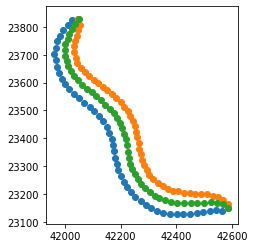

skid: 


In [12]:
# Test downasampling function on actual data: **visualise**.

with h5py.File(feature_file, "r") as f:
    dc_, vc_, sk_, skid_ = downsampled
    view_coord_frames(dc_, vc_, sk_, skid_, from_=0, to=40, print_raw=False)

## Invariant representation 

In [13]:
# Investigate a way to calculate the angles.

# TODO....

## Full run 

In [14]:
%%time



def preprocess_feature_file(feature_file, downsample_period=5, log=True):
    
    cleaned_key = "cleaned"
    downsampled_key = "downsampled"
    
    output = {cleaned_key: dict(), downsampled_key: dict(), "downsample_period": downsample_period}
    
    
    
    with h5py.File(feature_file, "r") as f:
        
        # Prep data.
        dc, vc, sk = retrieve_coordinates(f)
        skid = retrive_skeleton_ids(f)
        if log:
            print("\nShapes of dc, vc, sk, skid [original]:")
            print(dc.shape, vc.shape, sk.shape, skid.shape)

        skid_m, missing_for_any_reason = generate_missing(dc, vc, sk, skid)
        missing_frames_info(missing_for_any_reason, missing_indicator=1)



        # Clean.
        period_clean = 1
        clean_idx = get_downsample_clean_frames(missing_for_any_reason, period=1, keep_repeated=True, missing_indicator=1)
        to_clean = (dc, vc, sk, skid)
        dc_c, vc_c, sk_c, skid_c = downsample_clean(to_clean, clean_idx)  # Notation: _c --> _cleaned.
        # Check:
        assert dc_c.shape[0] == dc.shape[0]  # Total of frames.
        # Print:
        if log:
            print("\nShapes of dc_c, vc_c, sk_c, skid_c [cleaned]:")
            print(dc_c.shape, vc_c.shape, sk_c.shape, skid_c.shape)
        # Output:
        output[cleaned_key] = {"dc": dc_c, "vc": vc_c, "sk": sk_c, "skid": skid_c}

        # Downsample.
        downsample_idx = get_downsample_clean_frames(missing_for_any_reason, period=downsample_period, keep_repeated=True, missing_indicator=1)
        to_downsample = (dc, vc, sk, skid)
        dc_d, vc_d, sk_d, skid_d = downsample_clean(to_downsample, downsample_idx)  # Notation: _c --> _downsampled.
        # Print:
        if log:
            print("\nShapes of dc_d, vc_d, sk_d, skid_d [downsampled (and cleaned)]:")
            print(dc_d.shape, vc_d.shape, sk_d.shape, skid_d.shape)
            print()
        # Output:
        output[downsampled_key] = {"dc": dc_d, "vc": vc_d, "sk": sk_d, "skid": skid_d}



        # Normalise cleaned data.
        for key, (dc_, vc_, sk_) in { cleaned_key: (dc_c, vc_c, sk_c), downsampled_key: (dc_d, vc_d, sk_d) }.items():
            frame_data_dc_vc, frame_data_norm_dc_vc, com_dc_vc = normalise_dc_vc(dc_, vc_, limit=None)
            frame_data_sk, frame_data_norm_sk, com_sk = normalise_sk(sk_, limit=None)
            output[key]["normalised"] = {
                "dc_vc": {"data": frame_data_dc_vc, "data_norm": frame_data_norm_dc_vc, "com": com_dc_vc}, 
                "sk": {"data": frame_data_sk, "data_norm": frame_data_norm_sk, "com": com_sk} }

    return output



output = preprocess_feature_file(feature_file, downsample_period=5, log=True)


Shapes of dc, vc, sk, skid [original]:
(26997, 49, 2) (26997, 49, 2) (26997, 49, 2) (26997,)
Missing skeletons: 636/26997 (2.36%)
Longest run of missing skeletons: 272/26997 (1.01%)

Shapes of dc_c, vc_c, sk_c, skid_c [cleaned]:
(26997, 49, 2) (26997, 49, 2) (26997, 49, 2) (26997,)

Shapes of dc_d, vc_d, sk_d, skid_d [downsampled (and cleaned)]:
(5400, 49, 2) (5400, 49, 2) (5400, 49, 2) (5400,)

CPU times: user 14.6 s, sys: 107 ms, total: 14.7 s
Wall time: 14.7 s


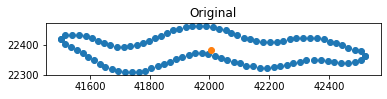

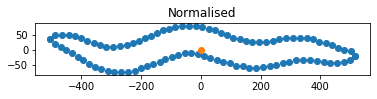

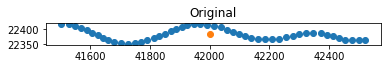

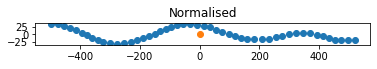

In [15]:
# Show some normalised data (from "cleaned").

t = 3  # Frame number.

frame_data, frame_data_norm, com = tuple(output["cleaned"]["normalised"]["dc_vc"].values())  # Note: dict key order is preserved by default from Python 3.7.
view_normalisation(frame_data, frame_data_norm, com, t=t)
frame_data, frame_data_norm, com = tuple(output["cleaned"]["normalised"]["sk"].values())
view_normalisation(frame_data, frame_data_norm, com, t=t)

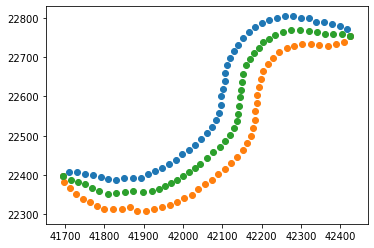

skid: 


In [16]:
# Show some frames.
dc_d, vc_d, sk_d, skid_d = tuple(list(output["downsampled"].values())[:4])
view_coord_frames(dc_d, vc_d, sk_d, skid_d, from_=0, to=40, print_raw=False)